## Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ye3ziuyd
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ye3ziuyd
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.

## Download the dataset

In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Setup configurations

In [4]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'
DEVICE = 'cuda'
epochs = 25
LR = 0.003
image_size = 320
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'
batch_size =16

In [5]:
df = pd.read_csv(csv_file)
df.head(3)

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [6]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask= cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

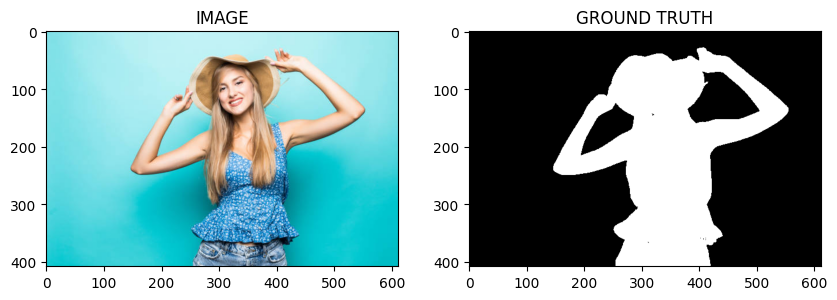

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [8]:
train_df,valid_df = train_test_split(df,test_size = 0.2,random_state=42)

## Augmentation Functions

In [9]:
import albumentations as a
def get_train_aug():
  return a.Compose([
      a.Resize(image_size,image_size),
      a.HorizontalFlip(p=0.5),
      a.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_aug():
    return a.Compose([
      a.Resize(image_size,image_size)

  ], is_check_shapes=False)

## Create Custom Dataset

In [10]:
from torch.utils.data import Dataset
class SegmentationDataset(Dataset):

  def __init__(self, df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):

    return len(self.df)


  def __getitem__(self,idx):
    row =  self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image =cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask,axis = -1) # Fix 1: Add channel at the end


    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32) # Fix 2: Transpose mask, not image

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)


    return image,mask

In [11]:
trainset = SegmentationDataset(train_df,get_train_aug())
validset = SegmentationDataset(valid_df,get_valid_aug())

In [12]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [32]:
idx = 42

image,mask = trainset[idx]

def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')



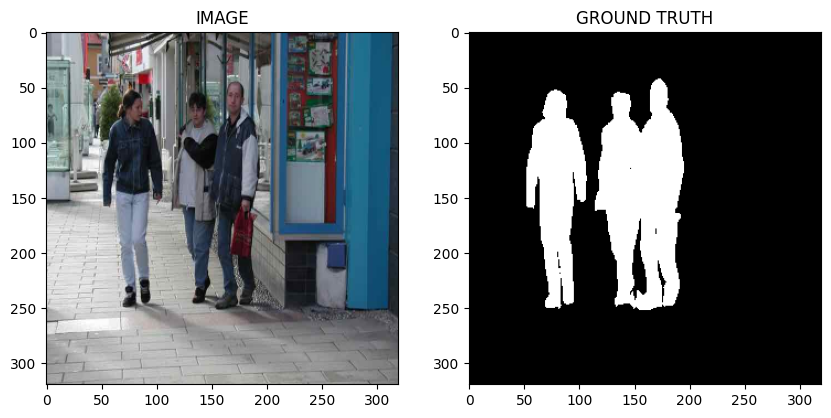

In [33]:
show_image(image,mask)

## Load dataset into batches

In [15]:
from torch.utils.data import DataLoader
train_loader = DataLoader(trainset,batch_size = batch_size,shuffle = True)
valid_loader = DataLoader(validset,batch_size = batch_size,shuffle = True)

In [16]:
print(f'Total number of batches:',len(train_loader))
print(f'Total number of batches:',len(valid_loader))

Total number of batches: 15
Total number of batches: 4


In [17]:
for image,mask in train_loader:
  break

print(f'One batch image and shape:', image.shape)
print(f'One batch mask and shape:', mask.shape)

One batch image and shape: torch.Size([16, 3, 320, 320])
One batch mask and shape: torch.Size([16, 1, 320, 320])


## Create Segmentation Model

In [18]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )


  def forward(self,images,masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)

      return logits,loss1+loss2

    return logits

In [20]:
model = SegmentationModel()
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

## Create Train and Validation Functions

In [21]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss = 0.0

  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss/len(data_loader)


In [22]:
def eval_fn(data_loader,model,optimizer):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits,loss = model(images,masks)
      total_loss += loss.item()
  return total_loss/len(data_loader)


## Train the Model

In [23]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [24]:
best_valid_loss = np.inf

for i in range(epochs):
  train_loss = train_fn(train_loader,model,optimizer)
  val_loss= eval_fn(valid_loader,model,optimizer)

if val_loss < best_valid_loss:
  torch.save(model.state_dict(),'best_model.pt')
  print('Saved model')
  best_valid_loss = val_loss

print(f"Epoch : {i+1} Train_loss :{train_loss} Valid_loss :{val_loss}")



100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

Saved model
Epoch : 25 Train_loss :0.10130287557840348 Valid_loss :0.20144843682646751


## Inference

In [35]:
idx = 42
model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

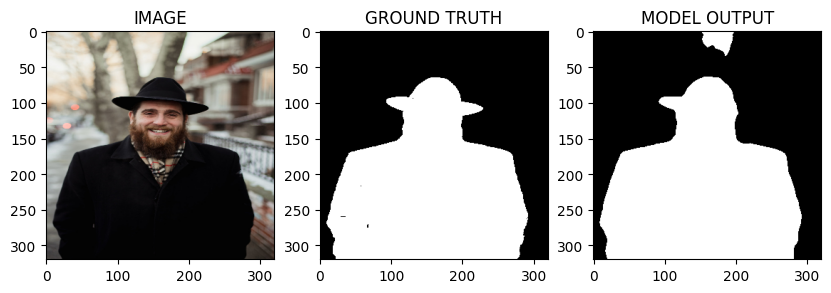

In [36]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))